# Simulation of Candidate Assessment and Item Responses

This notebook demonstrates a complete workflow for simulating candidate abilities, item parameters, and assessment outcomes using the 2-Parameter Logistic (2PL) Item Response Theory (IRT) model.  

Key steps include:  
1. **Generating candidates** with latent abilities ($\theta$) sampled from a standard normal distribution.  
2. **Visualizing the ability distribution** with a histogram.  
3. **Generating items** with discrimination ($a$) and difficulty ($b$) parameters across multiple skill types.  
4. **Simulating item responses** probabilistically using the 2PL model and Bernoulli draws.  
5. **Assigning project performance scores** correlated with latent ability, and categorizing them into `low`, `medium`, and `high`.  
6. **Visualizing relationships**:
   - Latent ability vs performance score  
   - Item characteristic curves (ICCs) including extreme and intermediate items  
7. **Linking the mathematical model to the visualizations**, showing how $\theta$, $a$, and $b$ influence response probabilities.  

This notebook provides a foundation for exploring assessment simulations, response modeling, and the interpretation of IRT-based evaluation metrics.


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit  # logistic (sigmoid) function
from IPython.display import display
import seaborn as sns

### 2-Parameter Logistic (2PL) Model

The **2-Parameter Logistic (2PL)** model in Item Response Theory (IRT) describes the probability that a candidate with latent ability ($\theta$) correctly answers an item.  
It incorporates two item-specific parameters:  
- **Discrimination** ($a$): how well the item differentiates between candidates of different ability levels.  
- **Difficulty** ($b$): the ability level at which the candidate has a 50% chance of answering correctly.

The model begines with a linear combination of candidate ability ($\theta$) and item parameters ($a$, $b$). 

**Interpretation:**
- A higher $\theta$ increases $z$, making a correct response more likely.  
- A higher $a$ **steepens the curve**, amplifying differences in ability near the difficulty level.  
- A higher $b$ shifts $z$ downward, making the item harder to answer correctly.

$$
z = a \cdot (\theta - b)
$$

It uses a **logistic (sigmoid) function** to transform $z$ into a probability of a correct response

$$
P(\text{correct}|\theta) = \frac{1}{1 + e^{-a(\theta - b)}}
$$


In [37]:
# =========================================================
# 1. Simulation parameters
# =========================================================

N_CANDIDATES = 300
N_ITEMS = 60
SKILL_TYPES = ["technical_skills", "logical_thinking", "oral_assessment", "creative_thinking"]

# Discrimination (a): how well item distinguishes high/low ability
A_MIN, A_MAX = 0.5, 2.0

# Difficulty (b): item difficulty (negative = easy, positive = hard)
B_MIN, B_MAX = -2, 2

#Saving data as
SAVE = "1"

np.random.seed(42)

### Understanding the Effects of Parameters in the 2PL Model

In the **2-Parameter Logistic (2PL)** model, the probability that a candidate with latent ability ($\theta$) answers an item correctly is given by:

$$
P(\text{correct}|\theta) = \frac{1}{1 + e^{-a(\theta - b)}}
$$

In the figure above:
- The **discrimination parameter** ($a$) controls the **steepness** of the curve.  
  - A higher $a$ produces a **steeper slope**, meaning the item better differentiates between low- and high-ability candidates near the difficulty point $b$.  
  - A lower $a$ yields a flatter curve, indicating less sensitivity to ability differences.
- The **difficulty parameter** ($b$) determines the **horizontal position** of the curve.  
  - A higher $b$ shifts the curve **to the right**, representing a harder item (requires higher $\theta$ to have a 50% chance of success).  
  - A lower $b$ shifts it **to the left**, representing an easier item.

Together, $a$ and $b$ shape the **Item Characteristic Curves (ICCs)** that describe how the probability of a correct response varies with latent ability.


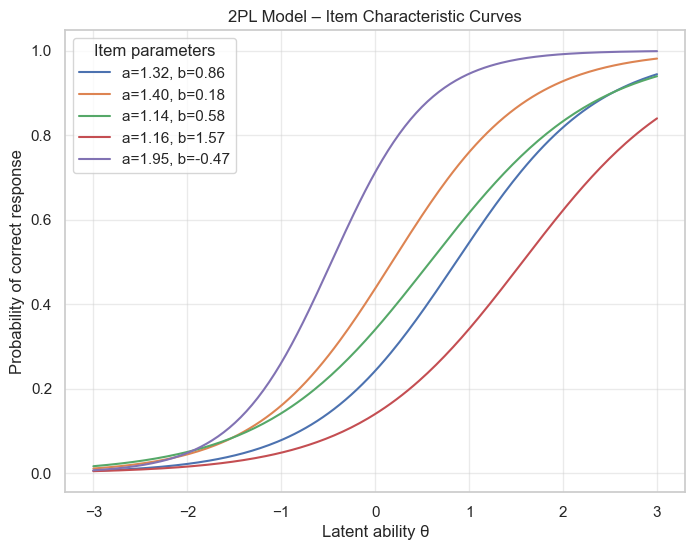

In [38]:
# =========================================================
# 2. 2PL model function
# =========================================================
def two_pl(theta, a, b):
    """2-Parameter Logistic Model"""
    return 1 / (1 + np.exp(-a * (theta - b)))

# =========================================================
# 3. Plot a few item characteristic curves (ICCs)
# =========================================================
thetas = np.linspace(-3, 3, 200)

plt.figure(figsize=(8, 6))
np.random.seed(0)

# plot 5 random items with random (a, b)
for i in range(5):
    a = np.random.uniform(A_MIN, A_MAX)
    b = np.random.uniform(B_MIN, B_MAX)
    p = two_pl(thetas, a, b)
    plt.plot(thetas, p, label=f"a={a:.2f}, b={b:.2f}")

plt.title("2PL Model – Item Characteristic Curves")
plt.xlabel("Latent ability θ")
plt.ylabel("Probability of correct response")
plt.legend(title="Item parameters")
plt.grid(alpha=0.4)
plt.show()

In [39]:
# =========================================================
# 2. Generating assessment questions
# =========================================================
def generate_items(n_items: int, skills: list):
    items = pd.DataFrame({
        "item_id": [f"Q{i+1}" for i in range(n_items)],
        "skill_type": np.random.choice(skills, size=n_items),
        "a": np.random.uniform(A_MIN, A_MAX, size=n_items),
        "b": np.random.uniform(B_MIN, B_MAX, size=n_items)
    })
    return items

items = generate_items(N_ITEMS, SKILL_TYPES)
display(items.head(10))

,item_id,skill_type,a,b
0,Q1,oral_assessment,1.039262,0.711266
1,Q2,creative_thinking,1.155548,-0.919968
2,Q3,creative_thinking,1.546447,0.940776
3,Q4,oral_assessment,0.590338,1.848754
4,Q5,technical_skills,1.500150,-1.004987
5,Q6,logical_thinking,1.505957,0.304629
6,Q7,logical_thinking,0.815574,0.368168
7,Q8,logical_thinking,0.693389,0.289008
8,Q9,logical_thinking,0.973143,-1.107673
9,Q10,technical_skills,1.045566,1.810996


In [40]:
# =========================================================
# 3. Generate candidates
# =========================================================
def generate_candidates(n_candidates: int):
    # True latent ability (θ) ~ N(0,1)
    candidates = pd.DataFrame({
        "candidate_id": [f"C{j+1}" for j in range(n_candidates)],
        "theta_true": np.random.normal(0, 1, n_candidates)
    })
    return candidates

candidates = generate_candidates(N_CANDIDATES)
display(candidates)

,candidate_id,theta_true
0,C1,-0.435154
1,C2,1.849264
2,C3,0.672295
3,C4,0.407462
4,C5,-0.769916
...,...,...
295,C296,0.582225
296,C297,-2.094603
297,C298,0.123722
298,C299,-0.130107


### Why Use a Normal Distribution for Latent Ability (θ)

In Item Response Theory (IRT), candidates' latent abilities ($\theta$) are typically assumed to follow a **normal distribution** with mean 0 and standard deviation 1, denoted as $\theta \sim \mathcal{N}(0, 1)$.  

This assumption reflects that:
- Most candidates have **average ability** (around 0).  
- **Fewer candidates** have very low or very high ability levels, following the familiar bell-shaped curve.  
- It provides a **standardized scale**, allowing item parameters and candidate abilities to be compared meaningfully across tests.

The histogram above visualizes this simulated distribution of $\theta$ values across all candidates.


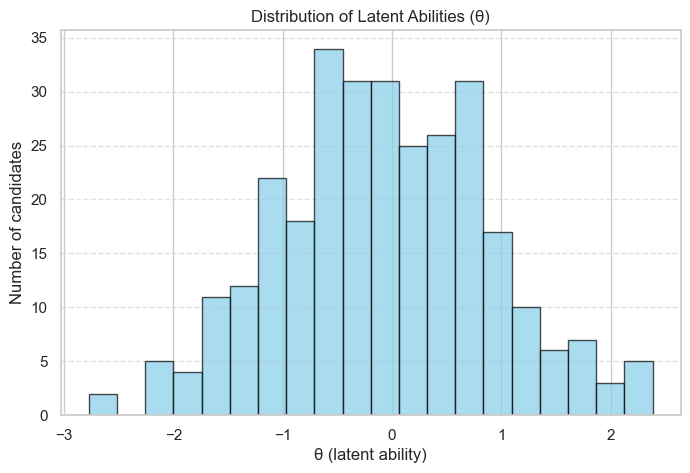

In [41]:
def plot_theta_distribution(candidates):
    """
    Plots a histogram of the latent ability distribution (theta_true)
    """
    plt.figure(figsize=(8, 5))
    plt.hist(candidates["theta_true"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Distribution of Latent Abilities (θ)")
    plt.xlabel("θ (latent ability)")
    plt.ylabel("Number of candidates")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

plot_theta_distribution(candidates)

### Bernoulli Draw for a Candidate

- The **sigmoid function** maps any real-valued input to the range [0, 1], producing probabilities that **saturate near 0 and 1** for very low or very high ability relative to item difficulty.  
- This allows each question to be probabilistically assigned a correct ($X=1$) or incorrect ($X=0$) response via a **binomial draw**, reflecting the uncertainty in real testing scenarios
    - A Bernoulli random variable $X$ with success probability $p$ (answering an item correctly) is defined as:

$$
P(X = x) =
\begin{cases} 
p & \text{if } x = 1 \\
1 - p & \text{if } x = 0
\end{cases}
$$

- The resulting simulated responses mimic realistic test behavior: most low-ability candidates fail hard items, high-ability candidates succeed on easy items, and uncertainty is highest for items near a candidate’s ability level.




In [42]:
# =========================================================
# 4. Simulate assessment responses under the 2PL model
# =========================================================
def simulate_responses(candidates: pd.DataFrame, items: pd.DataFrame):
    responses = []
    for _, cand in candidates.iterrows():
        for _, item in items.iterrows():
            p_correct = expit(item.a * (cand.theta_true - item.b))
            response = np.random.binomial(1, p_correct)
            responses.append({
                "candidate_id": cand.candidate_id,
                "item_id": item.item_id,
                "skill_type": item.skill_type,
                "response": response
            })
    df_responses = pd.DataFrame(responses)

    # Total assessment score per candidate
    total_scores = df_responses.groupby("candidate_id")["response"].sum().reset_index()
    total_scores.rename(columns={"response": "total_score"}, inplace=True)
    
    # Assessment score per skill type
    skill_scores = df_responses.groupby(["candidate_id", "skill_type"])["response"].sum().unstack(fill_value=0)
    
    # Merge scores back to candidates
    candidates = candidates.merge(total_scores, on="candidate_id")
    candidates = candidates.merge(skill_scores, on="candidate_id")
    
    return df_responses, candidates

responses, candidates_with_scores = simulate_responses(candidates, items)
display(candidates_with_scores.head(3))
display(responses)


,candidate_id,theta_true,total_score,creative_thinking,logical_thinking,oral_assessment,technical_skills
0,C1,-0.435154,22,5,8,5,4
1,C2,1.849264,45,12,13,10,10
2,C3,0.672295,48,15,15,7,11


,candidate_id,item_id,skill_type,response
0,C1,Q1,oral_assessment,0
1,C1,Q2,creative_thinking,1
2,C1,Q3,creative_thinking,0
3,C1,Q4,oral_assessment,0
4,C1,Q5,technical_skills,1
...,...,...,...,...
17995,C300,Q56,logical_thinking,0
17996,C300,Q57,creative_thinking,1
17997,C300,Q58,technical_skills,1
17998,C300,Q59,logical_thinking,1


### Relationship Between Latent Ability (θ) and Assessment Scores

The scatter plots illustrate how candidates' latent ability ($\theta$) relates to their performance on the assessment:

- **Total Assessment Score:** There is a clear positive trend, indicating that candidates with higher latent ability tend to achieve higher overall scores.  
- **Assessment Scores per Skill Type:** Each skill type shows a similar positive relationship with $\theta$, but the slope and spread may vary depending on the skill, reflecting differences in item difficulty and discrimination.  
- The plots highlight the probabilistic nature of the 2PL model: while higher ability generally leads to higher scores, some variability remains due to the stochastic element in responses.


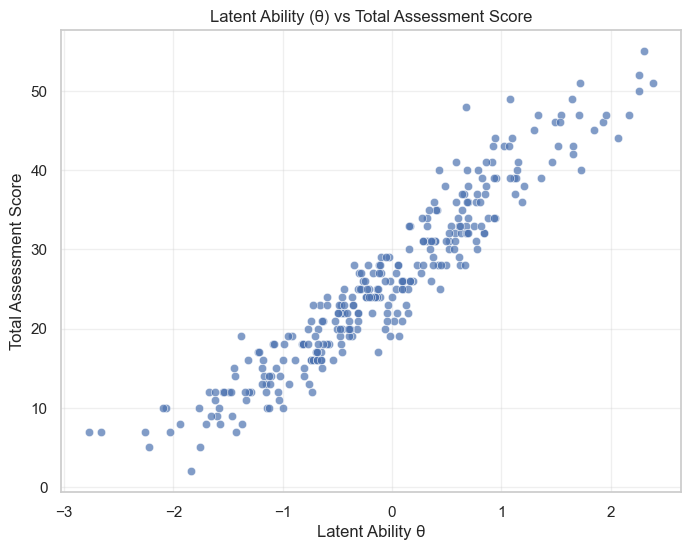

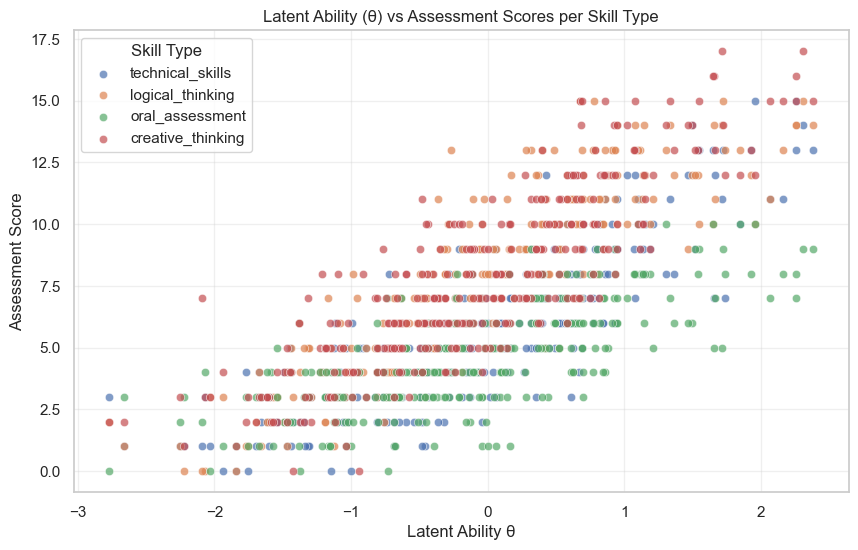

In [43]:
# Set a consistent style
sns.set(style="whitegrid")

# --- 1. Theta vs Total Assessment Score ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=candidates_with_scores,
    x="theta_true",
    y="total_score",
    alpha=0.7
)
plt.title("Latent Ability (θ) vs Total Assessment Score")
plt.xlabel("Latent Ability θ")
plt.ylabel("Total Assessment Score")
plt.grid(alpha=0.3)
plt.show()

# --- 2. Theta vs Assessment Score per Skill Type ---
plt.figure(figsize=(10, 6))
skill_types = SKILL_TYPES

for skill in skill_types:
    sns.scatterplot(
        data=candidates_with_scores,
        x="theta_true",
        y=skill,
        label=skill,
        alpha=0.7
    )

plt.title("Latent Ability (θ) vs Assessment Scores per Skill Type")
plt.xlabel("Latent Ability θ")
plt.ylabel("Assessment Score")
plt.legend(title="Skill Type")
plt.grid(alpha=0.3)
plt.show()

### Relationship Between Latent Ability (θ) and Work-performance Score

The scatter plot above illustrates the relationship between candidates' latent ability ($\theta$) and their simulated work-performance scores.  

Key assumptions:
- There is a **positive trend**: candidates with higher latent ability tend to achieve higher performance scores.  
- The added noise in the simulation introduces **variability**, so not all high-ability candidates achieve high scores and vice versa.  
- The **performance categories** (`low`, `medium`, `high`) correspond roughly to quantiles of the performance score, showing how the latent ability distribution influences outcome classification.


In [44]:
# =========================================================
# 5. Generate project outcomes
# =========================================================
def assign_project_performance(candidates: pd.DataFrame):
    # True performance correlated with ability (θ) + noise
    perf_score = candidates["theta_true"] + np.random.normal(0, 0.5, len(candidates))
    quantiles = np.quantile(perf_score, [0.33, 0.66])
    performance_label = pd.cut(
        perf_score,
        bins=[-np.inf, quantiles[0], quantiles[1], np.inf],
        labels=["low", "medium", "high"]
    )
    candidates["performance"] = performance_label
    candidates["performance_score"] = perf_score
    return candidates

candidates_project_performance = assign_project_performance(candidates)
display(candidates_project_performance)

,candidate_id,theta_true,performance,performance_score
0,C1,-0.435154,medium,-0.376678
1,C2,1.849264,high,2.553807
2,C3,0.672295,high,0.569210
3,C4,0.407462,medium,0.216151
4,C5,-0.769916,low,-0.732713
...,...,...,...,...
295,C296,0.582225,medium,0.257562
296,C297,-2.094603,low,-2.100837
297,C298,0.123722,medium,0.098183
298,C299,-0.130107,low,-0.631140


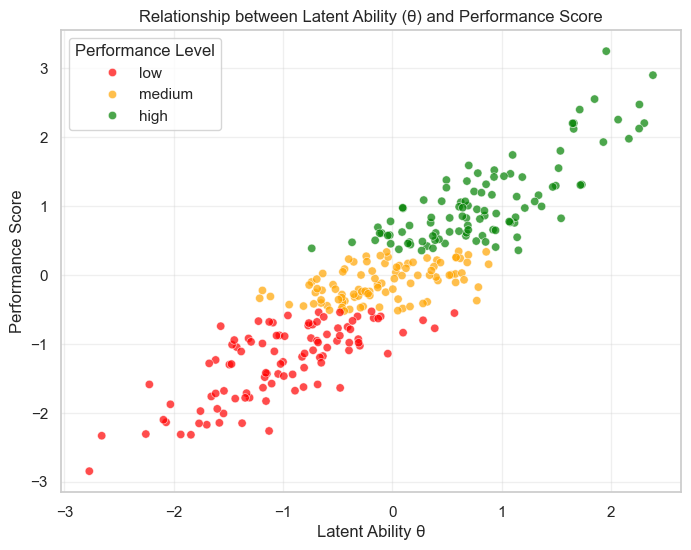

In [45]:
# Scatter plot: latent ability vs performance score
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=candidates,
    x="theta_true",
    y="performance_score",
    hue="performance",
    palette={"low": "red", "medium": "orange", "high": "green"},
    alpha=0.7
)
plt.title("Relationship between Latent Ability (θ) and Performance Score")
plt.xlabel("Latent Ability θ")
plt.ylabel("Performance Score")
plt.grid(alpha=0.3)
plt.legend(title="Performance Level")
plt.show()

In [46]:
# 3. Merge candidates_with_scores (assessment scores) with project performance
full_candidates = candidates_with_scores.merge(
    candidates[["candidate_id", "performance", "performance_score"]],
    on="candidate_id"
)

full_candidates.head()

,candidate_id,theta_true,total_score,creative_thinking,logical_thinking,oral_assessment,technical_skills,performance,performance_score
0,C1,-0.435154,22,5,8,5,4,medium,-0.376678
1,C2,1.849264,45,12,13,10,10,high,2.553807
2,C3,0.672295,48,15,15,7,11,high,0.569210
3,C4,0.407462,35,9,10,8,8,medium,0.216151
4,C5,-0.769916,20,9,4,4,3,low,-0.732713


### Relationship Between Total Assessment Score and Project Performance

The scatter plot shows how candidates' total assessment scores relate to their simulated project performance scores:

- There is a clear **positive trend**: candidates with higher total scores generally achieve higher performance scores.  
- Some **variability** exists due to the noise added in the performance simulation, reflecting real-world unpredictability.  
- The plot demonstrates that **assessment scores are predictive of project outcomes**, aligning with the intended correlation between latent ability, assessment performance, and project performance.


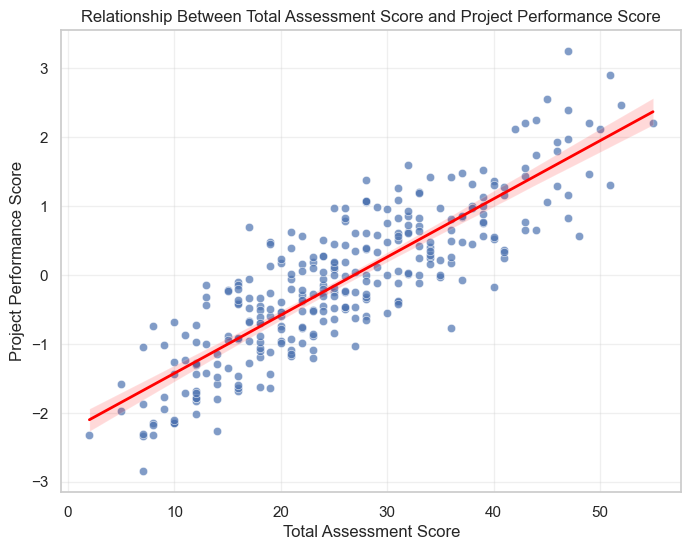

In [47]:
# Set Seaborn style
sns.set(style="whitegrid")

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=full_candidates,
    x="total_score",
    y="performance_score",
    alpha=0.7
)

# add a regression line
sns.regplot(
    data=full_candidates,
    x="total_score",
    y="performance_score",
    scatter=False,
    color='red',
    line_kws={"linewidth":2}
)

plt.title("Relationship Between Total Assessment Score and Project Performance Score")
plt.xlabel("Total Assessment Score")
plt.ylabel("Project Performance Score")
plt.grid(alpha=0.3)
plt.show()

In [53]:
# Save results
candidates_with_scores.to_csv(f"data/2pl_simulated_responses{SAVE}.csv", index=False)
items.to_csv(f"data/2pl_item_parameters{SAVE}.csv", index=False)
candidates_project_performance.to_csv(f"data/2pl_project_performance{SAVE}.csv", index=False)
responses.to_csv(f"data/responses{SAVE}.csv", index=False)

print("Files saved to /data folder.")

Files saved to /data folder.


## Conclusion and Insights

In this notebook, we simulated a full assessment workflow using the **2-Parameter Logistic (2PL) Item Response Theory (IRT) model**:

1. **Candidate generation:** Latent abilities ($\theta$) were sampled from a standard normal distribution to represent varying skill levels.  
2. **Item generation:** Items were assigned discrimination ($a$) and difficulty ($b$) parameters across multiple skill types.  
3. **Response simulation:** Candidate-item responses were probabilistically simulated using the 2PL model and Bernoulli draws, producing realistic item-level outcomes.  
4. **Assessment scoring:** Total assessment scores and skill-specific scores were computed for each candidate.  
5. **Project performance:** Scores were assigned based on latent ability plus noise, categorized into `low`, `medium`, and `high` performance.  
6. **Visualization and analysis:**  
   - Histograms of latent ability  
   - Item Characteristic Curves (ICCs) showing effects of $a$ and $b$  
   - Scatter plots of latent ability vs assessment scores and total scores vs project performance  

**Insights:**

- The 2PL model effectively links **latent ability, item properties, and response probabilities**, producing realistic assessment data.  
- **Discrimination ($a$)** controls the sensitivity of items to differences in ability, while **difficulty ($b$)** shifts the item curve along the ability axis.  
- Assessment scores are positively correlated with both latent ability and simulated project performance, illustrating that the model captures meaningful predictive relationships while allowing for natural variability.  
- This simulation framework provides a **flexible and interpretable way to explore assessment design, scoring, and performance prediction**.


## Future Applications and Next Steps

In the future, we aim to extend this simulation framework to **real-world assessment data**. The plan would involve:

1. **Parameter estimation:** Using methods like **Maximum Likelihood Estimation (MLE)** to estimate item parameters ($a$, $b$) and candidates’ latent abilities ($\theta$) from observed responses.  
2. **Predictive modeling:** Leveraging **machine learning techniques** to use the estimated parameters to predict **future work performance** of candidates.  
3. **Assessment optimization:** Using the insights gained to **tweak item parameters** and assessment design, with the goal of **selecting candidates who are more likely to perform well** in real-world projects.  

This approach would allow organizations to create **data-driven, interpretable, and predictive assessments**, improving both fairness and efficiency in candidate selection.
